# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [50]:
import numpy as np
import pandas as pd
from asl_data import AslDb



asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [51]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [52]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [53]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations

asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x'] 
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y'] 
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x'] 

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [54]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [55]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['VEGETABLE', 'SEE', 'GET', 'GIVE3', 'STOLEN', 'LAST-WEEK', 'PEOPLE', 'KNOW', 'NEXT-WEEK', 'TOY', 'ANN', 'FISH', 'BROCCOLI', 'DECIDE', 'CORN', 'PREFER', 'BREAK-DOWN', 'FIND', 'STUDENT', 'FRED', 'MOTHER', 'TELL', 'CAN', 'FINISH', 'WOMAN', 'SAY', 'GIVE1', 'CHOCOLATE', 'JOHN', 'CHICKEN', 'WHO', 'CORN1', 'ALL', 'BUT', 'READ', 'HOMEWORK', 'PARTY', 'LEG', 'POTATO', 'GO', 'MANY', 'MOVIE', 'HOUSE', 'FRANK', 'GROUP', 'GIRL', 'BILL', 'SOMETHING-ONE', 'NEW', 'CAR', 'WANT', 'NAME', 'SELF', 'GIVE2', 'YESTERDAY', 'WILL', 'LOVE', 'TEACHER', 'LEAVE', 'POSS', 'WONT', 'GO1', 'BOY', 'LIVE', 'BLAME', 'SHOOT', 'COAT', 'VIDEOTAPE', 'IX-1P', 'FUTURE', 'OLD', 'BROTHER', 'IX', 'PAST', 'FRIEND', 'CHINA', 'HERE', 'PUTASIDE', 'MARY', 'LIKE', 'FUTURE1', 'JANA', 'TOMORROW', 'WRITE', 'WHAT', 'SHOULD', 'HIT', 'BOX', 'THROW', 'BORROW', 'SELL', 'NEW-YORK', 'TOY1', 'HAVE', 'GO2', 'GIVE', 'SUE', 'SAY-1P', 'EAT', 'ARRIVE', 'SEARCH-FOR', 'CANDY', 'BOOK', 'VISIT', 'MAN', 'NOT', 'THINK', 'APPLE', 'BUY1', 'CHI

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [56]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [57]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [58]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [59]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker

df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [60]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd


asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['right-x-std'] = asl.df['speaker'].map(df_std['right-x']) 
asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean']) / asl.df['right-x-std']


asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])
asl.df['right-y-std'] = asl.df['speaker'].map(df_std['right-y']) 
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean']) / asl.df['right-y-std']

asl.df['left-x-std'] = asl.df['speaker'].map(df_std['left-x']) 
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean']) / asl.df['left-x-std']

asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['left-y-std'] = asl.df['speaker'].map(df_std['left-y']) 
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean']) / asl.df['left-y-std']



features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [61]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle


asl.df['polar-rr'] = np.sqrt(np.power((asl.df['right-x'] - asl.df['nose-x']),2) + np.power((asl.df['right-y'] - asl.df['nose-y']),2))

asl.df['polar-rtheta'] = np.arctan2((asl.df['right-x'] - asl.df['nose-x']),(asl.df['right-y'] - asl.df['nose-y']))

asl.df['polar-lr'] = np.sqrt(np.power((asl.df['left-x'] - asl.df['nose-x']),2) + np.power((asl.df['left-y'] - asl.df['nose-y']),2)) 

asl.df['polar-ltheta'] = np.arctan2((asl.df['left-x'] - asl.df['nose-x']),(asl.df['left-y'] - asl.df['nose-y']))


features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [62]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'


asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(value=0,axis=0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(value=0,axis=0)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(value=0,axis=0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(value=0,axis=0)



features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [63]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like



# TODO define a list named 'features_custom' for building the training set

features_custom = features_polar + features_ground + features_norm + features_delta

In [64]:
#Additional custom feature

asl.df['polar-lrr'] = np.sqrt(np.power((asl.df['left-x'] - asl.df['right-x']),2) + np.power((asl.df['left-y'] - asl.df['right-y']),2)) 

asl.df['polar-lrtheta'] = np.arctan2((asl.df['left-x'] - asl.df['right-x']),(asl.df['left-y'] - asl.df['right-y']))

features_custom_1 = ['polar-lrr','polar-lrtheta']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**

In [ ]:
I chose a combination of the above features for my features_custom set.
Each feature properly represents a subset of signs in the training set.
So a combination of these features would ensure that the number of signs that are properly represented is maximized

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [65]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.013s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [66]:
import warnings
import hmmlearn
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.113812743319


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [67]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]

hidden state #1
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #2
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [68]:
my_testword = 'YESTERDAY'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for YESTERDAY is 3
hidden state #0
mean =  [ -20.21568627   16.58823529   -5.39215686  124.62745098]
variance =  [  78.95367551   17.92868512  145.45425221   10.90061899]

hidden state #1
mean =  [-29.25714246  24.20000185  30.85714436  73.62857595]
variance =  [  13.73416368  135.30316677  447.89414575  240.40537987]

hidden state #2
mean =  [ -26.96666688   25.599998     32.16666505  162.36667106]
variance =  [  79.3658971    46.6403016    45.20586989  463.23242882]

logL = -1649.1753901205843


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [69]:
%matplotlib inline

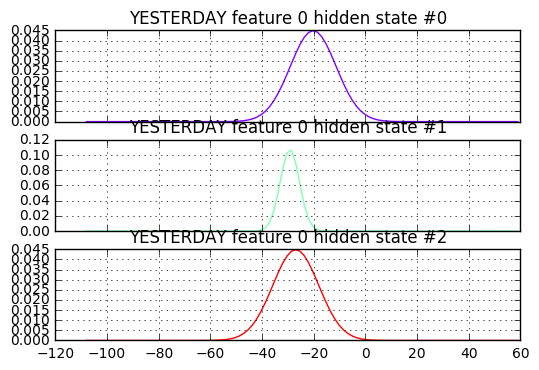

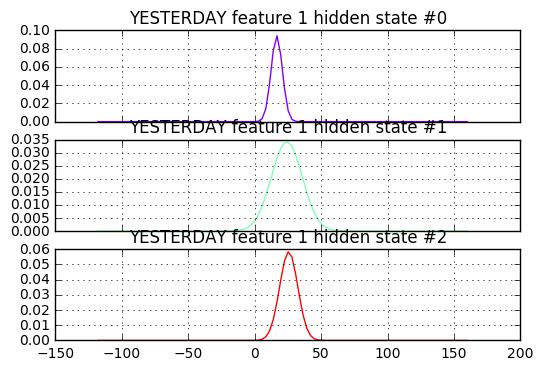

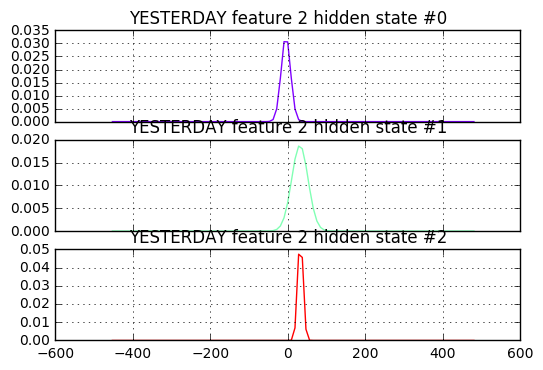

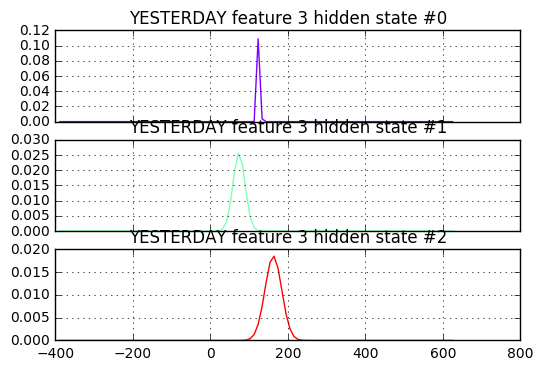

In [70]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `SelectorModel` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [71]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [72]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [73]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [74]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.6837943249993259 seconds
Training complete for BOOK with 15 states with time 4.892038762991433 seconds
Training complete for VEGETABLE with 15 states with time 1.5772266249987297 seconds
Training complete for FUTURE with 15 states with time 5.081705422009691 seconds
Training complete for JOHN with 15 states with time 45.40682860800007 seconds


In [75]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.34740090600098483 seconds
Training complete for BOOK with 8 states with time 2.0996272490010597 seconds
Training complete for VEGETABLE with 9 states with time 0.7540095200092765 seconds
Training complete for FUTURE with 9 states with time 2.23727736400906 seconds
Training complete for JOHN with 13 states with time 22.57090345499455 seconds


In [76]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.43383692399947904 seconds
Training complete for BOOK with 3 states with time 2.0033015130029526 seconds
Training complete for VEGETABLE with 3 states with time 0.7264578359900042 seconds
Training complete for FUTURE with 3 states with time 2.297324381012004 seconds
Training complete for JOHN with 3 states with time 21.272780735002016 seconds


In [77]:
from my_model_selectors import SelectorCV

training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 7 states with time 0.7867593539995141 seconds
Training complete for BOOK with 15 states with time 4.580826652992982 seconds
Training complete for VEGETABLE with 13 states with time 1.937765128997853 seconds
Training complete for FUTURE with 15 states with time 5.378273195005022 seconds
Training complete for JOHN with 15 states with time 38.2827373379987 seconds


In [78]:
from my_model_selectors import SelectorBIC

training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.3341131360066356 seconds
Training complete for BOOK with 5 states with time 2.06066849999479 seconds
Training complete for VEGETABLE with 5 states with time 0.8217329589970177 seconds
Training complete for FUTURE with 7 states with time 2.373840275002294 seconds
Training complete for JOHN with 15 states with time 21.52840509300586 seconds


In [79]:
from my_model_selectors import SelectorDIC

training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.38538671599235386 seconds
Training complete for BOOK with 3 states with time 1.9724637769977562 seconds
Training complete for VEGETABLE with 3 states with time 0.7742776810046053 seconds
Training complete for FUTURE with 3 states with time 2.3091742109972984 seconds
Training complete for JOHN with 3 states with time 19.98042380400875 seconds


In [80]:
from my_model_selectors import SelectorCV

training = asl.build_training(features_polar)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 8 states with time 0.7103705669869669 seconds
Training complete for BOOK with 14 states with time 5.168315363989677 seconds
Training complete for VEGETABLE with 15 states with time 1.9232886270037852 seconds
Training complete for FUTURE with 15 states with time 4.268149732990423 seconds
Training complete for JOHN with 15 states with time 56.7079988780024 seconds


In [81]:
from my_model_selectors import SelectorBIC

training = asl.build_training(features_polar)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.4535393900005147 seconds
Training complete for BOOK with 7 states with time 3.143614588989294 seconds
Training complete for VEGETABLE with 3 states with time 1.0620156380027765 seconds
Training complete for FUTURE with 4 states with time 2.086643030997948 seconds
Training complete for JOHN with 11 states with time 28.723761806002585 seconds


In [82]:
from my_model_selectors import SelectorDIC

training = asl.build_training(features_polar)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.3668368159997044 seconds
Training complete for BOOK with 3 states with time 2.4426976069953525 seconds
Training complete for VEGETABLE with 3 states with time 0.9435597139963647 seconds
Training complete for FUTURE with 3 states with time 2.0649078389978968 seconds
Training complete for JOHN with 3 states with time 27.426094295005896 seconds


In [83]:
from my_model_selectors import SelectorCV

training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 4 states with time 0.6356530710036168 seconds
Training complete for BOOK with 13 states with time 6.201624437991995 seconds
Training complete for VEGETABLE with 14 states with time 1.7084884720097762 seconds
Training complete for FUTURE with 5 states with time 3.9497487710032146 seconds
Training complete for JOHN with 15 states with time 58.89732917200308 seconds


In [84]:
from my_model_selectors import SelectorBIC

training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 4 states with time 0.3482060399983311 seconds
Training complete for BOOK with 8 states with time 3.25850554300996 seconds
Training complete for VEGETABLE with 3 states with time 0.8627119300072081 seconds
Training complete for FUTURE with 5 states with time 2.0240089489961974 seconds
Training complete for JOHN with 6 states with time 29.615284165993216 seconds


In [85]:
from my_model_selectors import SelectorDIC

training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.3824796239932766 seconds
Training complete for BOOK with 3 states with time 3.4364121520047775 seconds
Training complete for VEGETABLE with 3 states with time 0.9872170079906937 seconds
Training complete for FUTURE with 3 states with time 2.327193396995426 seconds
Training complete for JOHN with 3 states with time 29.07568038199679 seconds


In [86]:
from my_model_selectors import SelectorCV

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.8111071019957308 seconds
Training complete for BOOK with 15 states with time 3.869339590004529 seconds
Training complete for VEGETABLE with 15 states with time 1.6317509960063035 seconds
Training complete for FUTURE with 15 states with time 3.118826532008825 seconds
Training complete for JOHN with 15 states with time 62.89988767700561 seconds


In [87]:
from my_model_selectors import SelectorBIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.4363013919937657 seconds
Training complete for BOOK with 12 states with time 1.9239549869962502 seconds
Training complete for VEGETABLE with 7 states with time 0.8646391539950855 seconds
Training complete for FUTURE with 7 states with time 1.801761020993581 seconds
Training complete for JOHN with 14 states with time 35.41361689699988 seconds


In [88]:
from my_model_selectors import SelectorDIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.34235708200139925 seconds
Training complete for BOOK with 3 states with time 1.771975982002914 seconds
Training complete for VEGETABLE with 3 states with time 0.7874475970020285 seconds
Training complete for FUTURE with 3 states with time 1.5697171380015789 seconds
Training complete for JOHN with 3 states with time 30.204441816997132 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

In [ ]:
In general DIC uses fewer states to represent words compared to DIC and CV.
BIC uses fewer states to represent words compared to CV.
Both BIC and DIC are faster in training compared to CV.
BIC requires less computational time and DIC uses a reference dictionaty to speed up computation.
CV is slower because for each model selection, it calls a KFold(cross reference) method
DIC is the fastest model selector

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [89]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 54.660s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [90]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [91]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [97]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors


In [98]:
# TODO Choose a feature set and model selector
features = features_polar 
model_selector = SelectorCV
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities_, guesses = recognize(models, test_set)
show_errors(guesses, test_set)



**** WER = 0.5337078651685393
Total correct: 83 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: *SHOULD FUTURE *MARY BUY HOUSE                                JOHN FUTURE NOT BUY HOUSE
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
  201: JOHN *GIVE *LOVE *JOHN BUY HOUSE                              JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *GO *GO *VISIT                                            JOHN NOT VISIT MARY
  119: *MARY *BUY1 IX *BLAME *IX                                     SUE BUY IX CAR BLUE
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   77: *JOHN *GIVE1 MARY                                             ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [99]:
# TODO Choose a feature set and model selector
features = features_custom 
model_selector = SelectorCV
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities_, guesses = recognize(models, test_set)
show_errors(guesses, test_set)



**** WER = 0.5056179775280899
Total correct: 88 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: JOHN FUTURE *JOHN BUY HOUSE                                   JOHN FUTURE NOT BUY HOUSE
    7: JOHN *JOHN GO CAN                                             JOHN CAN GO CAN
  201: JOHN *FUTURE *IX *WOMAN BUY HOUSE                             JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *MARY *MARY *IX                                           JOHN NOT VISIT MARY
  119: *MARY *BUY1 IX *JOHN *GO                                      SUE BUY IX CAR BLUE
   12: JOHN CAN *JOHN CAN                                            JOHN CAN GO CAN
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [100]:
# TODO Choose a feature set and model selector
features = features_custom 
model_selector = SelectorDIC
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities_, guesses = recognize(models, test_set)
show_errors(guesses, test_set)



**** WER = 0.5674157303370787
Total correct: 77 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: *POSS WRITE HOMEWORK                                          JOHN WRITE HOMEWORK
   67: *TELL FUTURE *MARY BUY HOUSE                                  JOHN FUTURE NOT BUY HOUSE
    7: JOHN *PEOPLE *IX *ARRIVE                                      JOHN CAN GO CAN
  201: JOHN *MAN *IX *IX BUY HOUSE                                   JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *MARY *MARY MARY                                          JOHN NOT VISIT MARY
  119: *MARY *BUY1 *CAR CAR *HAVE                                    SUE BUY IX CAR BLUE
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   77: *IX BLAME MARY                                                ANN BLAME MARY
  142: *FRANK BUY YESTERDAY WHAT BOOK                 

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

In [ ]:
The WER results from three combinations of features and model selectors are as follows:

1. features_custom and SelectorDIC WER = 5674157303370787   
2. features_custom and SelectorCV WER = 0.5056179775280899
3. features_polar and SelectorCV WER = 0.5337078651685393  


The best combination is features_custom and SelectorCV because it yields the lowest WER(0.50)

A Statistical Language Model can be used to improve WER



<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [101]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 30.285s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [102]:
#Different approach using model ensemble

from my_model_selectors import SelectorConstant
from my_model_selectors import SelectorCV
from my_model_selectors import SelectorBIC
from my_model_selectors import SelectorDIC

probabilities = []
features = [features_custom_1,features_custom,features_norm,features_delta,features_polar,features_ground]
selectors = [SelectorConstant,SelectorCV,SelectorBIC,SelectorDIC]

for feature in features:
    for selector in selectors:
        model_selector = selector
        models = train_all_words(feature , model_selector)
        test_set = asl.build_test(feature)
        temp_probabilities, guesses = recognize(models, test_set)
        probabilities.append(temp_probabilities)
        print("completed model with feature:{} and model selector:{}".format(feature,selector))
        


completed model with feature:['polar-lrr', 'polar-lrtheta'] and model selector:<class 'my_model_selectors.SelectorConstant'>
completed model with feature:['polar-lrr', 'polar-lrtheta'] and model selector:<class 'my_model_selectors.SelectorCV'>
completed model with feature:['polar-lrr', 'polar-lrtheta'] and model selector:<class 'my_model_selectors.SelectorBIC'>
completed model with feature:['polar-lrr', 'polar-lrtheta'] and model selector:<class 'my_model_selectors.SelectorDIC'>
completed model with feature:['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta', 'grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly', 'norm-rx', 'norm-ry', 'norm-lx', 'norm-ly', 'delta-rx', 'delta-ry', 'delta-lx', 'delta-ly'] and model selector:<class 'my_model_selectors.SelectorConstant'>
completed model with feature:['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta', 'grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly', 'norm-rx', 'norm-ry', 'norm-lx', 'norm-ly', 'delta-rx', 'delta-ry', 'delta-lx', 'delta-ly'] and mod

In [131]:
#add and average all probabilities
#output error

probabilities_avg = []
guesses = []
for index,word_Logl_dict in enumerate(probabilities[0]):
    probabilities_avg.append({})
    for word in word_Logl_dict:
        probabilities_avg[index][word] = probabilities[0][index][word]
        count = 0
        for i in range(1,len(probabilities),1):
            if probabilities[i][index][word] != float('-inf'):
                probabilities_avg[index][word] += probabilities[i][index][word]
                count += 1
        probabilities_avg[index][word] /= count
    guesses.append(max(probabilities_avg[index], key=probabilities_avg[index].get))   
show_errors(guesses, test_set)  


**** WER = 0.4606741573033708
Total correct: 96 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: JOHN FUTURE *MARY BUY HOUSE                                   JOHN FUTURE NOT BUY HOUSE
    7: JOHN CAN GO *WHAT                                             JOHN CAN GO CAN
  201: JOHN *MARY *IX *WOMAN BUY HOUSE                               JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *MARY *MARY MARY                                          JOHN NOT VISIT MARY
  119: *MARY *BUY1 IX CAR *IX                                        SUE BUY IX CAR BLUE
   12: JOHN *WHAT *WHAT CAN                                          JOHN CAN GO CAN
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [104]:
# Save
np.save('./probabilities_avg.npy', probabilities_avg) 
np.save('./probabilities.npy', probabilities) 



In [130]:
#Load
probabilities_avg = np.load('./probabilities_avg.npy')
probabilities = np.load('./probabilities.npy')

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [132]:

# create a DataFrame of log likelihoods for the test word items
import arpa

df_probs = pd.DataFrame(data=probabilities_avg)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-3942.066364,-1.840698e+05,-7006.023218,-424.651279,-40941.134014,-364.685380,-7081.693569,-894.204537,-11525.332890,-582.064921,...,-1959.148234,-273.968501,-76481.986301,-410.933721,-239.795599,-9045.431873,-812.534091,-970.658545,-621.633778,-342.386411
1,-10036.437719,-2.108075e+05,-23040.408078,-195.528421,-46716.540328,-318.608748,-8701.455953,-205.261418,-3288.909685,-486.312018,...,-309.554075,-434.435982,-67981.553299,-380.093485,-445.053949,-18359.912064,-483.385699,-1006.962301,-140.462751,-569.436021
2,-14566.347905,-8.132935e+05,-34431.317622,-429.322673,-80519.018015,-610.156211,-16244.887549,-856.559055,-6042.451046,-962.150238,...,-1140.297862,-707.851142,-168769.044031,-781.011916,-857.395609,-25343.239305,-1270.102156,-1527.568602,-873.941236,-940.928815
3,-1788.451607,-1.949594e+06,-1969.928633,-408.698041,-5355.695501,-485.419668,-2136.081488,-1668.553875,-51506.072718,-722.613534,...,-3186.551032,-294.818107,-239862.753395,-500.081675,-507.211798,-12469.759172,-361.170116,-925.657230,-4133.306622,-567.694972
4,-2579.527298,-8.794753e+05,-9595.813621,-119.258054,-120475.756993,-113.671330,-941.441412,-206.427598,-3165.643029,-99.603037,...,-461.141461,-111.686897,-80618.177065,-114.714171,-349.651845,-11016.503061,-236.561767,-854.455571,-706.066577,-283.015010


In [123]:
from asl_data import SinglesData

#print(probabilities_avg[1].items(), key=lambda x: x[1])


def calculate_WER(guesses: list, test_set: SinglesData,scale=0):
    """ Print WER and sentence differences in tabular form
    :param guesses: list of test item answers, ordered
    :param test_set: SinglesData object
    :return:
        nothing returned, prints error report
    WER = (S+I+D)/N  but we have no insertions or deletions for isolated words so WER = S/N
    """
    S = 0
    N = len(test_set.wordlist)
    num_test_words = len(test_set.wordlist)
    if len(guesses) != num_test_words:
        print("Size of guesses must equal number of test words ({})!".format(num_test_words))
    for word_id in range(num_test_words):
        if guesses[word_id] != test_set.wordlist[word_id]:
            S += 1

    print("\n**** WER = {} with LM scale factor : {}".format(float(S) / float(N),scale))   
       

In [127]:
#1-gram

model = arpa.loadf("./SLM/ukn.1.lm")
lm_1 = model[0]

for i in range(0,20):
    propabilities_lm = []
    for propabilities in probabilities_avg:
        temp = {}
        for k,v in  sorted(propabilities.items(), key=lambda x: x[1])[::-1][0:6]:
            k_copy = k
            if "1" ==  k[len(k)-1:len(k)] or "2" in k or "3" in k:
                k_copy = k[:len(k)-1]
            temp[k] = (i) * lm_1.log_p(k_copy) + v
        propabilities_lm.append(temp)
    guesses=[]    
    for propabilities  in propabilities_lm:
        guesses.append(max(propabilities, key=propabilities.get))
    calculate_WER(guesses, test_set,i)    
        


**** WER = 0.4606741573033708 with LM scale factor : 0

**** WER = 0.4606741573033708 with LM scale factor : 1

**** WER = 0.47752808988764045 with LM scale factor : 2

**** WER = 0.47191011235955055 with LM scale factor : 3

**** WER = 0.47191011235955055 with LM scale factor : 4

**** WER = 0.47191011235955055 with LM scale factor : 5

**** WER = 0.47191011235955055 with LM scale factor : 6

**** WER = 0.47191011235955055 with LM scale factor : 7

**** WER = 0.47191011235955055 with LM scale factor : 8

**** WER = 0.47191011235955055 with LM scale factor : 9

**** WER = 0.47191011235955055 with LM scale factor : 10

**** WER = 0.47191011235955055 with LM scale factor : 11

**** WER = 0.47752808988764045 with LM scale factor : 12

**** WER = 0.46629213483146065 with LM scale factor : 13

**** WER = 0.46629213483146065 with LM scale factor : 14

**** WER = 0.47752808988764045 with LM scale factor : 15

**** WER = 0.48314606741573035 with LM scale factor : 16

**** WER = 0.483146067415

In [125]:
#2-gram

model = arpa.loadf("./SLM/ukn.2.lm")
lm_2 = model[0]

for i in range(0,20):
    probabilities_lm = []
    for index,probabilities in enumerate(probabilities_avg):
        temp = {}
        for k,v in sorted(probabilities_avg[index].items(), key=lambda x: x[1])[::-1][0:6]:
            k_copy = k
            if "1" ==  k[len(k)-1:len(k)] or "2" in k or "3" in k:
                k_copy = k[:len(k)-1]
            str_ =' '
            if len(probabilities_lm) == 0:
                str_ = '<s>'+' '+k_copy
            else:
                dict_ = probabilities_lm[len(probabilities_lm)-1]
                previous_str = max(dict_, key=dict_.get)    
                str_ = previous_str+' '+k_copy
            temp[k] = (i * lm_2.log_p(str_)) + v
            #print('prop for {} is {} calculated value: {} '.format(str_,lm_2.log_p(str_),temp[k]))    
        probabilities_lm.append(temp)
    guesses=[]
    for probabilities  in probabilities_lm:
        guesses.append(max(probabilities, key=probabilities.get))
    #print(guesses)                       
    calculate_WER(guesses, test_set,i) 


  
    


**** WER = 0.4606741573033708 with LM scale factor : 0

**** WER = 0.47191011235955055 with LM scale factor : 1

**** WER = 0.4606741573033708 with LM scale factor : 2

**** WER = 0.4606741573033708 with LM scale factor : 3

**** WER = 0.4550561797752809 with LM scale factor : 4

**** WER = 0.449438202247191 with LM scale factor : 5

**** WER = 0.4438202247191011 with LM scale factor : 6

**** WER = 0.4438202247191011 with LM scale factor : 7

**** WER = 0.4438202247191011 with LM scale factor : 8

**** WER = 0.4438202247191011 with LM scale factor : 9

**** WER = 0.449438202247191 with LM scale factor : 10

**** WER = 0.4606741573033708 with LM scale factor : 11

**** WER = 0.46629213483146065 with LM scale factor : 12

**** WER = 0.47191011235955055 with LM scale factor : 13

**** WER = 0.46629213483146065 with LM scale factor : 14

**** WER = 0.47191011235955055 with LM scale factor : 15

**** WER = 0.47191011235955055 with LM scale factor : 16

**** WER = 0.47191011235955055 with 

In [126]:
#3-gram
model = arpa.loadf("./SLM/ukn.3.lm")
lm_3 = model[0]


for i in range(0,20):
    propabilities_lm = []
    for index,propabilities in enumerate(probabilities_avg):
        temp = {}
        for k,v in propabilities.items():
            k_copy = k
            if "1" ==  k[len(k)-1:len(k)] or "2" in k or "3" in k:
                k_copy = k[:len(k)-1]
            if len(propabilities_lm) == 0:
                str = '<s>'+' '+'<s>'+' '+k_copy
                temp[k] = (i * lm_3.log_p(str)) + v
            elif len(propabilities_lm) == 1:
                dict_ = propabilities_lm[len(propabilities_lm)-1]
                previous_str = max(dict_, key=dict_.get)    
                str = '<s>'+' '+previous_str+' '+k_copy
                temp[k] = (i * lm_3.log_p(str)) + v
            else:
                dict_1 = propabilities_lm[len(propabilities_lm)-1]
                dict_2 = propabilities_lm[len(propabilities_lm)-2]
                previous_str_1 = max(dict_1, key=dict_1.get)
                previous_str_2 = max(dict_2, key=dict_2.get)
                str = previous_str_2+' '+previous_str_1+' '+k_copy
                temp[k] = (i * lm_3.log_p(str)) + v                  
        propabilities_lm.append(temp)
    guesses=[]    
    for propabilities  in propabilities_lm:
        guesses.append(max(propabilities, key=propabilities.get))
    calculate_WER(guesses, test_set,i) 


**** WER = 0.4606741573033708 with LM scale factor : 0

**** WER = 0.46629213483146065 with LM scale factor : 1

**** WER = 0.47191011235955055 with LM scale factor : 2

**** WER = 0.46629213483146065 with LM scale factor : 3

**** WER = 0.46629213483146065 with LM scale factor : 4

**** WER = 0.4550561797752809 with LM scale factor : 5

**** WER = 0.46629213483146065 with LM scale factor : 6

**** WER = 0.47191011235955055 with LM scale factor : 7

**** WER = 0.48314606741573035 with LM scale factor : 8

**** WER = 0.48314606741573035 with LM scale factor : 9

**** WER = 0.4887640449438202 with LM scale factor : 10

**** WER = 0.4887640449438202 with LM scale factor : 11

**** WER = 0.4887640449438202 with LM scale factor : 12

**** WER = 0.4943820224719101 with LM scale factor : 13

**** WER = 0.4943820224719101 with LM scale factor : 14

**** WER = 0.4943820224719101 with LM scale factor : 15

**** WER = 0.4943820224719101 with LM scale factor : 16

**** WER = 0.5 with LM scale fac

In [ ]:
A WER of 0.4438202247191011 was achieved after applying 2-gram LM